# Análise da Rentabilidade de Fundos

### Inicializações

In [1]:
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sn

encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
cotacoes_xls = 'historico_cotacoes.xlsx'

In [2]:
#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

Date
2022-10-29    1.00350
2022-10-28    1.00350
2022-10-27    1.00290
2022-10-26    0.99208
2022-10-25    1.00420
Name: USD2EUR, dtype: float64

### Obter informação de cotações

In [3]:
#Read XLS
dict_df = pd.read_excel(cotacoes_xls,sheet_name=None)

# Parse the date and set it as index
for key in dict_df.keys():
    dict_df[key]['Date'] = dict_df[key].apply(lambda x: pd.to_datetime(x['Date'], infer_datetime_format = True).date(), axis=1)
    dict_df[key].set_index('Date',drop=True, inplace=True)

# Create the DataFrame from the Dictionary of Dataframes, removing rows with null values
df_cotacoes = pd.concat([dict_df[f_name][['Close']].rename(columns={'Close':f_name}) for f_name in dict_df.keys()],axis=1).sort_index(ascending=False).fillna(method='bfill').fillna(method='pad')

df_cotacoes.head()


,IE00BLP5S353,LU0121204431,LU0122613903,LU0171310955,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007,LU0384381660,LU0494093627,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,LU1670715975,LU0213962813,LU1176912761,LU1046545411
Date,,,,,,,,,,,,,,,,,,,,
2022-10-28,1.35,478.37,18.62,44.98,42.26,53.27,269.55,34.55,10.7,60.26,42.76,405.71,308.82,10.61,109.40,727.84,37.97,31.50,115.20,9.65
2022-10-27,1.36,468.20,18.62,44.98,41.91,53.27,280.41,35.20,10.7,60.43,42.71,405.71,307.80,10.53,109.40,727.84,37.81,32.18,115.41,9.61
2022-10-26,1.36,468.65,18.62,44.98,41.82,53.27,277.24,34.89,10.7,59.54,42.66,408.26,304.03,10.45,109.39,739.00,37.94,32.74,114.67,9.44
2022-10-25,1.36,473.83,18.62,44.98,41.71,53.27,270.56,34.63,10.7,58.80,42.67,405.70,303.16,10.50,109.40,731.73,37.74,33.11,114.97,9.37
2022-10-24,1.37,467.56,18.62,44.98,41.04,53.27,273.65,35.11,10.7,58.62,42.36,400.94,302.32,10.51,109.38,720.12,37.49,33.41,116.39,9.44


### Obter informação de transações

In [4]:
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)

# Criar Dataframe de Portofolio Actual
df_portofolio = df_transacoes[pd.isnull(df_transacoes['Data de resgate'])].drop(columns=['Data de resgate','Cotacao de resgate']).copy()

i = 0
while df_cotacoes.index[i] > exchange_rates.index[0]:
    exchange_rates[df_cotacoes.index[i]] = exchange_rates[0]
    i += 1
    
last_date = min(df_cotacoes.index[0],exchange_rates.index[0])
# Get the exchange rate for the last date of the historical quotes
usd2eur = exchange_rates.loc[last_date]

df_portofolio['Data da cotacao'] = df_cotacoes.index[0]
df_portofolio['cotacao actual'] = df_portofolio.apply(lambda x: df_cotacoes[x['Code']][0] * (usd2eur if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio['Dias'] = (df_portofolio['Data da cotacao']-df_portofolio['Data de subscricao']).apply(lambda x: x.days)

# Criar Dataframe com o Historico
df_historico = df_transacoes[pd.notnull(df_transacoes['Data de resgate'])].copy()
df_historico['Dias'] = (df_historico['Data de resgate']-df_historico['Data de subscricao']).apply(lambda x: x.days)

In [5]:
df_historico['Cotacao de Subscricao'].astype(float)

14     300.591244
15     297.952626
16     316.543768
18      43.744966
19      43.744966
          ...    
249    198.270000
250    201.860000
251     33.420000
252     32.471040
253     32.471040
Name: Cotacao de Subscricao, Length: 211, dtype: float64

### Cálculo Rentabilidade do Histórico

In [6]:
df_historico['Rentabilidade anual %'] = df_historico.apply(lambda x: 100*(math.pow(x['Cotacao de resgate']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_historico['Rentabilidade Absoluta'] = df_historico['Cotacao de resgate']*100/df_historico['Cotacao de Subscricao']-100
df_historico['Valor Actual'] = df_historico['Quantidade']*df_historico['Cotacao de resgate']

print("Rentabilidade Absoluta", sum(df_historico['Quantidade']*df_historico['Cotacao de resgate'])*100/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])-100)

df_historico['Ganho Absoluto'] = df_historico['Quantidade']*(df_historico['Cotacao de resgate']-df_historico['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_historico['Ganho Absoluto']),'em', sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao']))

dias_medio = (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']*df_historico['Dias']).sum() / (df_historico['Quantidade']*df_historico['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_historico['Ganho Absoluto'].sum()/sum(df_historico['Quantidade']*df_historico['Cotacao de Subscricao'])+1, float(365.0/dias_medio))-1))


Rentabilidade Absoluta 6.29304554700218
Ganho Absoluto 20184.307853153816 em 320739.8977553668
Rentabilidade Média Anual 8.601683960056317


In [7]:
df_historico.sort_values(by=['Data de resgate'],ascending=False)

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
50,LU0248173006,SIC Asia B accum EUR,22.790,2022-06-27,42.688100,EUR,2022-10-24,35.106300,119,-45.105899,-17.760922,800.072577,-172.789222
47,LU0171309270,BGF Healthscience E2 EUR,46.090,2022-07-25,54.200000,EUR,2022-10-24,54.240000,91,0.296343,0.073801,2499.921600,1.843600
32,LU2210151697,FF Abs Ret Gb Eq,107.780,2022-08-22,10.407211,USD,2022-10-24,10.489451,63,4.665851,0.790221,1130.552985,8.863827
31,LU2210151697,FF Abs Ret Gb Eq,272.810,2022-07-29,10.239811,USD,2022-10-24,10.489451,87,10.633667,2.437934,2861.627015,68.104237
23,LU0823417141,BNP Health Care In\tN Capit,6.124,2022-07-25,408.120000,EUR,2022-10-17,404.320000,84,-3.983294,-0.931099,2476.055680,-23.271200
...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,LU0260085492,Jupiter Europ Grw,13.920,2017-07-06,31.280000,EUR,2019-06-06,35.920000,700,7.478599,14.833760,500.006400,64.588800
59,LU0171310955,BGF Wor Techn EUR E,51.780,2017-04-20,19.440000,EUR,2019-06-06,28.970000,777,20.610796,49.022634,1500.066600,493.463400
58,LU0171310955,BGF Wor Techn EUR E,34.520,2017-04-20,19.440000,EUR,2019-06-06,28.970000,777,20.610796,49.022634,1000.044400,328.975600
113,LU1548497772,A Artific Intellig,8.305,2017-07-07,104.060000,EUR,2019-06-05,120.411000,698,7.930468,15.713050,1000.013355,135.795055


### Cálculo Rentabilidade do Portfólio

In [8]:
df_portofolio['Rentabilidade anual %'] = df_portofolio.apply(lambda x: 100*(math.pow(x['cotacao actual']/x['Cotacao de Subscricao'],
                                                        float(365.0/x['Dias']))-1), axis=1)

df_portofolio['Rentabilidade Absoluta'] = df_portofolio['cotacao actual']*100/df_portofolio['Cotacao de Subscricao']-100
df_portofolio['Valor Actual'] = df_portofolio['Quantidade']*df_portofolio['cotacao actual']
print("Rentabilidade Absoluta", sum(df_portofolio['Valor Actual'])*100/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])-100)

df_portofolio['Ganho Absoluto'] = df_portofolio['Quantidade']*(df_portofolio['cotacao actual']-df_portofolio['Cotacao de Subscricao'])
print("Ganho Absoluto", sum(df_portofolio['Ganho Absoluto']),'em', sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']),'=', sum(df_portofolio['Valor Actual']))

dias_medio = (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']*df_portofolio['Dias']).sum() / (df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao']).sum()
print("Rentabilidade Média Anual", 100*(math.pow(df_portofolio['Ganho Absoluto'].sum()/sum(df_portofolio['Quantidade']*df_portofolio['Cotacao de Subscricao'])+1, 
                                                 float(365.0/dias_medio))-1))


Rentabilidade Absoluta -0.5509447184372647
Ganho Absoluto -658.5354641403355 em 119528.41040172533 = 118869.874937585
Rentabilidade Média Anual -2.223535311985181


In [9]:
df_portofolio.groupby(by=["Code","Nome"]).sum()[['Quantidade','Valor Actual','Ganho Absoluto']]

,,Quantidade,Valor Actual,Ganho Absoluto
Code,Nome,,,
IE00BD3B6K23,MAN Emerg Debt Total R D USD,136.9830,15038.390991,257.060726
IE00BLP5S353,Jupiter Glb Abs Rt,8711.3190,11801.441632,1825.203249
LU0094557526,MFS European Research A1 EUR,85.0860,3595.734360,5.288290
LU0108459040,Candriam Biotech C Cap USD,7.2710,5310.647076,7.857076
LU0121204431,NN Glb Sustain Eq,7.1900,3439.480300,-321.585760
LU0122613903,T Eastern Europe,32.1960,599.489520,-400.518240
LU0171309270,BGF Healthscience E2 EUR,64.2900,3424.728300,-59.789700
LU0171310955,BGF Wor Techn EUR E,172.9100,7777.491800,-1293.523400
LU0213962813,HSBC Turkey Equity Eur,46.3050,1458.607500,158.594625


In [10]:
df_portofolio[df_portofolio['Code']=='LU0171310955']

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data da cotacao,cotacao actual,Dias,Rentabilidade anual %,Rentabilidade Absoluta,Valor Actual,Ganho Absoluto
69,LU0171310955,BGF Wor Techn EUR E,72.29,2022-07-25,49.40,EUR,2022-10-28,44.98,95,-30.241440,-8.947368,3251.6042,-319.5218
70,LU0171310955,BGF Wor Techn EUR E,100.62,2022-08-16,54.66,EUR,2022-10-28,44.98,73,-62.264586,-17.709477,4525.8876,-974.0016


<AxesSubplot:xlabel='Date'>

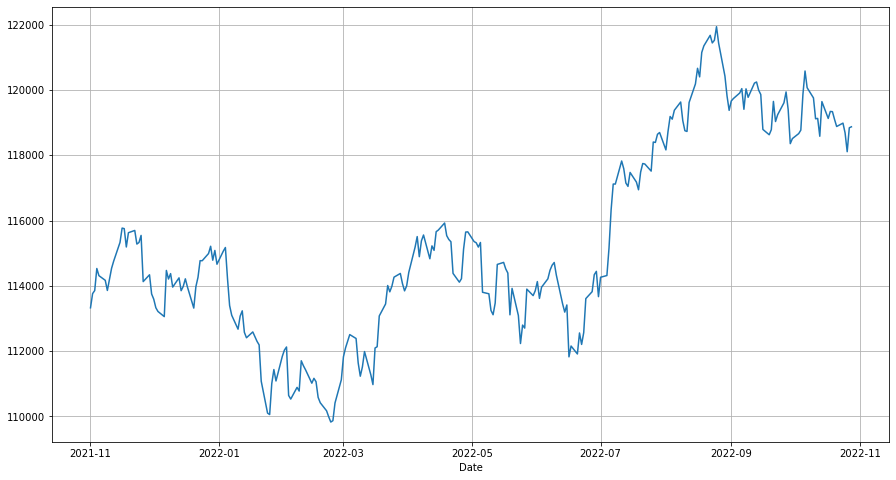

In [11]:
#Get the Portofolio
size=260
portfolio_csv = 'portofolio.csv'
df_meta = pd.read_csv(portfolio_csv ,sep=';').set_index('Code')
df_global = df_cotacoes[:size].apply(lambda x: sum(df_meta['Quantidade'][k]*v*(exchange_rates[x.name] if df_meta['Moeda'][k] == 'USD' else 1) for k,v in x.items()),axis=1)        
df_global[:].plot(figsize=(15,8),grid=True)

In [12]:
start =31
stop = 0
df_global_grow = (df_global / df_global.shift(-1)).dropna()
growth = (df_global.iloc[stop]/df_global.iloc[start]-1)
growth_abs = df_global.iloc[stop] - df_global.iloc[start]
std = df_global_grow.std()
'Growth ABS = {:.2f}, Growth = {:.2%}, STD = {:.6f}, Racio = {:.3f}'.format(growth_abs, growth,std,growth/std)

'Growth ABS = -988.62, Growth = -0.82%, STD = 0.004503, Racio = -1.832'

# SP 500 Comparision

In [15]:
# https://www.spglobal.com/spdji/en/indices/equity/sp-500/#overview
df_sp500 = pd.read_excel('PerformanceGraphExport.xls', sheet_name="Performance Graph", header=None, names=['Date','Value'], usecols="A:B", skiprows=7).dropna()
ds_sp500 = df_sp500['Value']
ds_sp500.index = df_sp500['Date'].apply(lambda x: x.date())
ds_sp500 = ds_sp500.reindex(pd.date_range(ds_sp500.index.min(),ds_sp500.index.max())).interpolate()
ds_sp500

2012-09-28    1625.65
2012-09-29    1625.43
2012-09-30    1625.21
2012-10-01    1624.99
2012-10-02    1622.74
               ...   
2022-10-24    6782.73
2022-10-25    6841.88
2022-10-26    6730.60
2022-10-27    6723.91
2022-10-28    6923.40
Freq: D, Name: Value, Length: 3683, dtype: float64

In [16]:
df_sp500_hist = df_historico[['Dias']].copy()
df_sp500_hist['Cost'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_hist['Quantidade'] = df_historico.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_hist['Net'] = df_sp500_hist['Quantidade']*df_historico.apply(lambda x: (ds_sp500[pd.to_datetime(x['Data de resgate'])]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_hist['Cost']*df_sp500_hist['Dias']).sum() / df_sp500_hist['Cost'].sum()
print("SP500 Histórico: Custo={}, Ganho={}".format(df_sp500_hist['Cost'].sum(),df_sp500_hist['Net'].sum()))
print("Rentabilidade SP500 Histórico", 100*(math.pow(df_sp500_hist['Net'].sum()/sum(df_sp500_hist['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))


SP500 Histórico: Custo=320739.89775536617, Ganho=44277.59666189995
Rentabilidade SP500 Histórico 19.105960963252166


In [17]:
df_sp500_portf = df_portofolio[['Code']].copy()
df_portf_tmp = df_portofolio[df_portofolio['Data de subscricao'].apply(lambda x: pd.to_datetime(x)) <= ds_sp500.index.max()]
df_sp500_portf['Days'] = df_portf_tmp.apply(lambda x: (dict_df[x['Code']].index.max() - x['Data de subscricao']).days, axis=1)
df_sp500_portf['Quantidade'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao']/ds_sp500[pd.to_datetime(x['Data de subscricao'])],axis=1)
df_sp500_portf['Cost'] = df_portf_tmp.apply(lambda x: x['Quantidade']*x['Cotacao de Subscricao'],axis=1)
df_sp500_portf['Net'] = df_sp500_portf['Quantidade']*df_portf_tmp.apply(lambda x: (ds_sp500.loc[ds_sp500.index.max()]-ds_sp500[pd.to_datetime(x['Data de subscricao'])]),axis=1)
dias_medio = (df_sp500_portf['Cost']*df_sp500_portf['Days']).sum() / df_sp500_portf['Cost'].sum()
print("SP500 Portfolio: Custo={}, Ganho={}".format(df_sp500_portf['Cost'].sum(),df_sp500_portf['Net'].sum()))
print("Rentabilidade SP500 Portfolio at {}".format(ds_sp500.index.max()), 100*(math.pow(df_sp500_portf['Net'].sum()/sum(df_sp500_portf['Cost'])+1, 
                                                 float(365.0/dias_medio))-1))

SP500 Portfolio: Custo=119528.41040172534, Ganho=407.00312425619546
Rentabilidade SP500 Portfolio at 2022-10-28 00:00:00 1.4698039905467475


<AxesSubplot:>

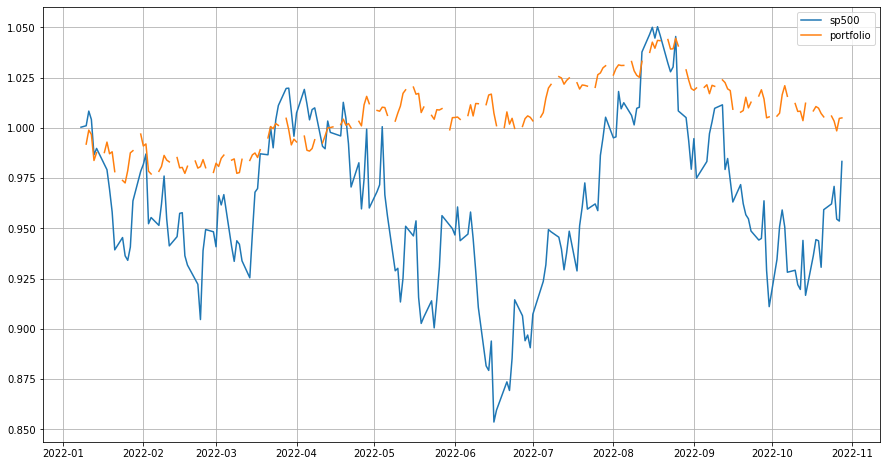

In [18]:
n_days = 210
first_date = df_cotacoes.index[n_days] #df_cotacoes.index.min()
df_t = df_transacoes[df_transacoes['Code'].isin(df_cotacoes.columns)].copy()
portf_perform = []
df_tmp = df_t[(df_t['Data de subscricao']<=first_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>first_date))]
last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][first_date] * (exchange_rates.loc[first_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
for i_date in df_cotacoes.index[:n_days+1].sort_values()[1:]:
    df_tmp = df_t[(df_t['Data de subscricao']<i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=i_date))]
    new_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
    portf_perform.append(new_val/last_val-1.0)
    df_tmp = df_t[(df_t['Data de subscricao']<=i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>i_date))]
    last_val = df_tmp.apply(lambda x: x['Quantidade']*df_cotacoes[x['Code']][i_date] * (exchange_rates.loc[i_date] if x['Moeda'] == 'USD' else 1), axis=1).sum()
portf_perform = pd.Series(data=portf_perform, index= df_cotacoes.index[:n_days+1].sort_values()[1:], name="portfolio")

sp500_perform = []
last_val = ds_sp500[pd.to_datetime(first_date)]
for i_date in ds_sp500[pd.to_datetime(first_date):].index[1:]:
    sp500_perform.append(ds_sp500[i_date]/last_val-1.0)
    last_val = ds_sp500[i_date]

sp500_perform = pd.Series(data=sp500_perform, index= [x.date() for x in ds_sp500[pd.to_datetime(first_date):].index[1:]], name="sp500")

pd.concat([sp500_perform.cumsum()+1, portf_perform.cumsum()+1],axis=1).plot(figsize=(15,8),grid=True)


In [19]:
set(df_t['Data de subscricao']) - set(df_cotacoes.index) 

{datetime.date(2017, 4, 20), datetime.date(2020, 7, 28)}

In [20]:
i_date = pd.to_datetime('2021-03-28').date()
df_tmp = df_t[(df_t['Data de subscricao']<i_date) & ((pd.isnull(df_t['Data de resgate'])) | (df_t['Data de resgate']>=i_date))]
df_tmp

,Code,Nome,Quantidade,Data de subscricao,Cotacao de Subscricao,Moeda,Data de resgate,Cotacao de resgate
64,LU0171310955,BGF Wor Techn EUR E,44.790,2020-07-28,47.110000,EUR,2021-08-02,60.280000
65,LU0171310955,BGF Wor Techn EUR E,33.120,2020-07-28,47.110000,EUR,2021-11-01,60.380000
66,LU0171310955,BGF Wor Techn EUR E,21.160,2020-07-28,47.110000,EUR,2022-09-12,38.920000
78,LU0121204431,NN Glb Sustain Eq,2.373,2020-07-28,395.280000,EUR,2022-09-12,512.290000
82,LU0121204431,NN Glb Sustain Eq,0.464,2021-03-01,514.930000,EUR,2022-10-10,461.360000
83,LU0121204431,NN Glb Sustain Eq,1.478,2021-03-01,514.930000,EUR,NaN,NaN
102,IE00BLP5S353,Jupiter Glb Abs Rt,1216.122,2021-03-09,0.961302,USD,2022-02-28,1.165344
103,IE00BLP5S353,Jupiter Glb Abs Rt,1948.610,2021-03-24,0.994525,USD,2022-02-28,1.165344
104,IE00BLP5S353,Jupiter Glb Abs Rt,2323.047,2021-03-24,0.994525,USD,2022-08-15,1.280011


In [21]:

df_cotacoes[pd.to_datetime('2020-08-02').date():pd.to_datetime('2020-06-25').date()]

,IE00BLP5S353,LU0121204431,LU0122613903,LU0171310955,LU0094557526,LU0171309270,LU0244354824,LU0248173006,PTSQUGHM0007,LU0384381660,LU0494093627,LU0823417141,LU1769942746,LU2210151697,IE00BD3B6K23,LU0108459040,LU1670715975,LU0213962813,LU1176912761,LU1046545411
Date,,,,,,,,,,,,,,,,,,,,
